<a href="https://colab.research.google.com/github/Marcellinus08/Deep-Learning/blob/main/Training_and_Deploying_at_Scale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import json
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt

Checking GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    print("Disabling virtual GPU configuration...")
    tf.config.experimental.set_visible_devices([], 'GPU') # Disable virtual devices
    physical_gpus = tf.config.experimental.list_physical_devices('GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(f"Physical GPUs: {len(physical_gpus)}, Logical GPUs: {len(logical_gpus)}")
  except RuntimeError as e:
    print("Error:", e)
else:
    print("No GPU found.")


Disabling virtual GPU configuration...
Physical GPUs: 1, Logical GPUs: 0


Data Preparation

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full[..., np.newaxis].astype(np.float32) / 255.
X_test = X_test[..., np.newaxis].astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]


Build and Training Base Model

In [4]:
with tf.device('/CPU:0'):
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28, 1]),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=keras.optimizers.SGD(learning_rate=1e-2),
                  metrics=["accuracy"])
    model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid), verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7207 - loss: 1.0637 - val_accuracy: 0.9014 - val_loss: 0.3695
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8968 - loss: 0.3697 - val_accuracy: 0.9188 - val_loss: 0.3013
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9119 - loss: 0.3164 - val_accuracy: 0.9284 - val_loss: 0.2685
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9229 - loss: 0.2822 - val_accuracy: 0.9338 - val_loss: 0.2461
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9273 - loss: 0.2584 - val_accuracy: 0.9360 - val_loss: 0.2267


Save Model

In [5]:
model_name = "my_mnist_model"
model_version = "0001"
model_dir = os.path.join("/content/", model_name, model_version)
print(f"\nMenyimpan model ke direktori: {model_dir}")
model.export(model_dir)

print("\nStruktur direktori SavedModel:")
!ls -lR {os.path.join("/content/", model_name)}


Menyimpan model ke direktori: /content/my_mnist_model/0001
Saved artifact at '/content/my_mnist_model/0001'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140639311518544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140639311519504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140639311518928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140639311519312: TensorSpec(shape=(), dtype=tf.resource, name=None)

Struktur direktori SavedModel:
/content/my_mnist_model:
total 4
drwxr-xr-x 4 root root 4096 Jun 20 11:29 0001

/content/my_mnist_model/0001:
total 48
drwxr-xr-x 2 root root  4096 Jun 20 11:26 assets
-rw-r--r-- 1 root root    57 Jun 20 11:29 fingerprint.pb
-rw-r--r-- 1 root root 33571 Jun 20 11:29 saved_model.pb
drwxr-xr-x 2 root root  4096 Jun 20 11:29 variables

TensorFlow Serving

In [6]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update
!apt-get install tensorflow-model-server


deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2943  100  2943    0     0   6612      0 --:--:-- --:--:-- --:--:--  6613
OK
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jam

In [7]:
os.environ["MODEL_DIR"] = os.path.join("/content/", model_name)

In [8]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=my_mnist_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


In [9]:
print("\nServer TF Serving sedang dimulai di background...")
time.sleep(5)


Server TF Serving sedang dimulai di background...


In [10]:

X_new = X_test[:3]
request_json = json.dumps({
    "signature_name": "serving_default",
    "instances": X_new.tolist()
})
SERVER_URL = "http://localhost:8501/v1/models/my_mnist_model:predict"


Query berhasil!
Prediksi dari server: [7 2 1]
Label sebenarnya:   [7 2 1]


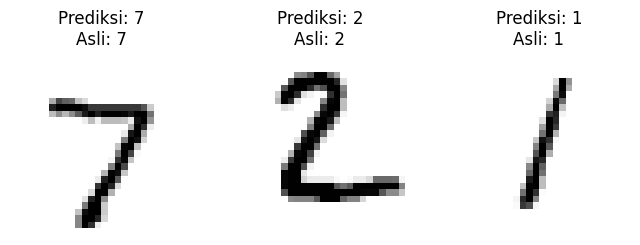

In [11]:
try:
    response = requests.post(SERVER_URL, data=request_json)
    response.raise_for_status()
    response_data = response.json()

    print("Query berhasil!")
    y_proba = np.array(response_data["predictions"])
    y_pred = np.argmax(y_proba, axis=1)

    print(f"Prediksi dari server: {y_pred}")
    print(f"Label sebenarnya:   {y_test[:3]}")

    plt.figure(figsize=(8, 4))
    for index, image in enumerate(X_new):
        plt.subplot(1, 3, index + 1)
        plt.imshow(image.squeeze(), cmap="binary")
        plt.title(f"Prediksi: {y_pred[index]}\nAsli: {y_test[index]}")
        plt.axis("off")
    plt.show()

except Exception as e:
    print(f"\nError saat melakukan Query: {e}")
    print("\n--- Log Server (server.log) ---")
    !cat server.log

Distribution Training with MirroredStrategy

In [12]:
distribution = tf.distribute.MirroredStrategy()
with distribution.scope():
    mirrored_model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28, 1]),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10)
    ])
    optimizer = keras.optimizers.Adam()
    loss_function = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    mirrored_model.compile(loss=loss_function,optimizer=optimizer,metrics=["accuracy"])

history_dist = mirrored_model.fit(X_train, y_train, epochs=10,validation_data=(X_valid, y_valid), verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8635 - loss: 0.4792 - val_accuracy: 0.9598 - val_loss: 0.1359
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9617 - loss: 0.1332 - val_accuracy: 0.9712 - val_loss: 0.0985
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9731 - loss: 0.0875 - val_accuracy: 0.9740 - val_loss: 0.0878
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9810 - loss: 0.0638 - val_accuracy: 0.9756 - val_loss: 0.0797
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9845 - loss: 0.0519 - val_accuracy: 0.9768 - val_loss: 0.0762
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9876 - loss: 0.0400 - val_accuracy: 0.9780 - val_loss: 0.0700
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9917 - loss: 0.0290 - val_accuracy: 0.9786 - val_loss: 0.0703
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9921 - loss: 0.0265

Evaluate

In [13]:
print("\nEvaluasi akhir model:")
loss, accuracy = mirrored_model.evaluate(X_test, y_test)
print(f"Loss Test: {loss:.4f}, Akurasi Test: {accuracy:.4f}")



Evaluasi akhir model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9731 - loss: 0.1015
Loss Test: 0.0882, Akurasi Test: 0.9762


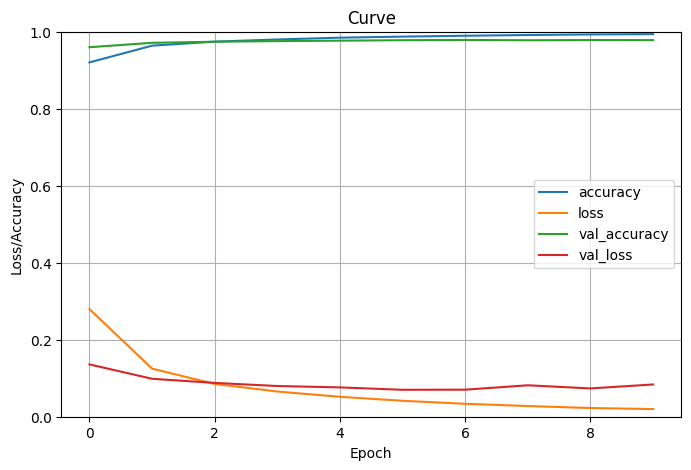

In [14]:
pd.DataFrame(history_dist.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.show()